## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('Libraries')
import signal_processing as spl 
spl = reload(spl)

In [2]:
# from python_speech_features import mfcc, logfbank
# import peakutils
# import numpy as np
# from matplotlib import mlab
# from matplotlib import cm
# from matplotlib import animation
# import scipy as sp

## File of Raw Recording (.m4a, .wav, whatever) and text input

In [3]:
raw_file = '2sent.m4a'
text = "last night, my wifes boss frm her brand new job invited us over or dinner. On the drive over, my wife reiterated many times to me just how important it was to make a good impression."
print len(text)

182


## Get raw signal

.wav file location: 2sent.wav
rate: 48000 measurements per second
length of audio: 26.8999791667 seconds
rate * length =  1291200 measurements


,signal
time (s),
0.000000,-130
0.000021,-223
0.000042,-271
0.000063,-272
0.000083,-265


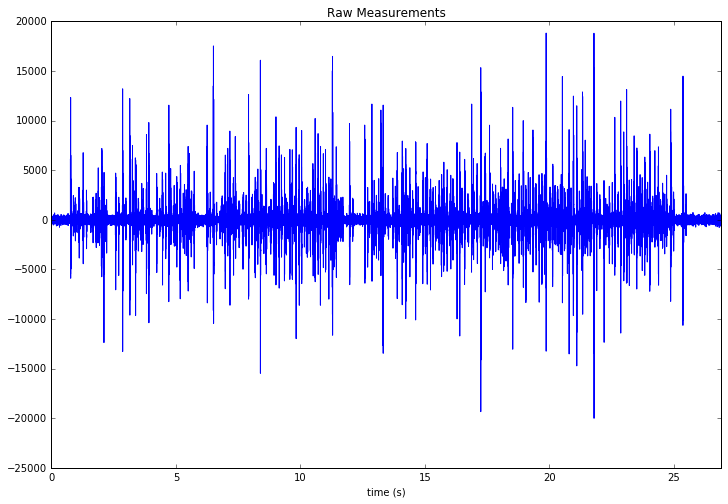

In [4]:
signal_df, rate, wav_file = spl.open_audio(raw_file, verbose = True, head = 5, plt_every = 2**5)

## Compute the windowed discrete-time Fourier transform of a signal using a sliding window

freqs.shape (129,) min: 0.0 max 24000.0
[   0.   187.5  375.   562.5  750. ]

fourier_df:


,signal
count,5764.000000
mean,1915.975342
std,9742.630035
min,0.010579
25%,27.436602
50%,46.119978
75%,281.429375
max,301307.312500


,signal
time (s),
0.002667,26.988041
0.007333,23.840269
0.012000,29.308170
0.016667,25.083809
0.021333,28.108290


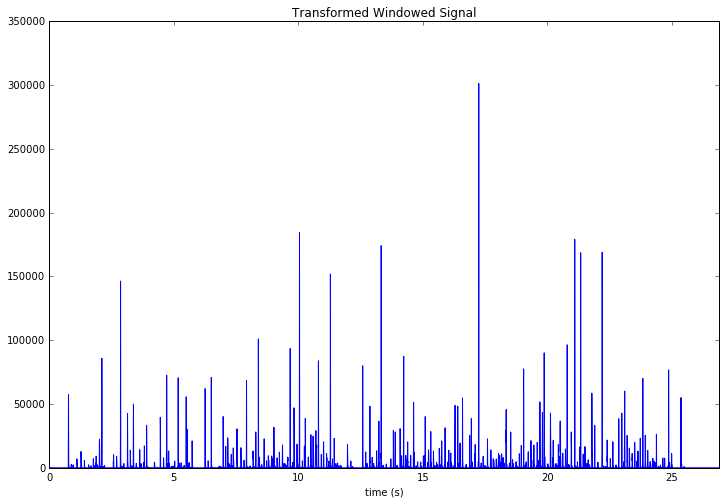

In [5]:
freqs, fourier_df = spl.get_windowed_fourier(signal_df, rate, MIN_FREQ = 400, MAX_FREQ = 12000, verbose = True, head = 5)

## Determine Windows in subset of audio

time range: 1.00s - 26.90s
Number of Keys detected: 183
peaks


,peak time,signal,start time,end time
count,183.000000,183.000000,183.000000,183.000000
mean,13.931774,31405.289062,13.913774,13.889774
std,6.730026,40770.328034,6.730026,6.730026
min,1.104000,2494.067383,1.086000,1.062000
25%,8.675667,8315.895996,8.657667,8.633667
50%,14.390000,17544.363281,14.372000,14.348000
75%,19.647000,38529.343750,19.629000,19.605000
max,25.366000,301307.312500,25.348000,25.324000


,peak time,signal,start time,end time
0,1.104000,7048.185059,1.086000,1.062000
1,1.267333,12784.041016,1.249333,1.225333
2,1.407333,5925.564453,1.389333,1.365333
3,1.766667,7128.171387,1.748667,1.724667
4,1.878667,9161.909180,1.860667,1.836667
5,2.014000,22366.277344,1.996000,1.972000
6,2.107333,85812.898438,2.089333,2.065333
7,2.578667,10235.539062,2.560667,2.536667
8,2.700000,8952.230469,2.682000,2.658000
9,2.858667,146393.375000,2.840667,2.816667


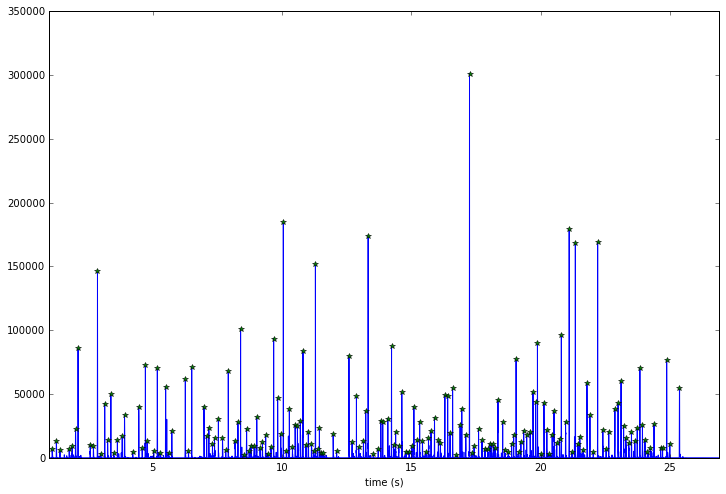

In [10]:
sfourier_df, ssignal_df, peaks = spl.detect_peaks(fourier_df, signal_df, t0 = 1.0, t1 = signal_df.index[-1], min_thresh = 2350,
                                           max_thresh = 500000, MIN_DIST = 13, KEY_LEN = 60, back_prop = .3)

In [11]:
peaks.head()

,peak time,signal,start time,end time
0,1.104000,7048.185059,1.086000,1.062000
1,1.267333,12784.041016,1.249333,1.225333
2,1.407333,5925.564453,1.389333,1.365333
3,1.766667,7128.171387,1.748667,1.724667
4,1.878667,9161.909180,1.860667,1.836667


In [13]:
sfourier_df.head()

,signal,is_peak
time (s),,
1.001333,25.680923,False
1.006000,26.725206,False
1.010667,38.326717,False
1.015333,40.483414,False
1.020000,24.519876,False


25.895333333333333

In [41]:
MAX_FRAMES = 20
FRAME_BREAK = 3.
SLOWDOWN = 2.
figsz = (12,8)
input_df = sfourier_df



In [37]:
import scipy.io.wavfile as wav
wav.write("subset_sound.wav", rate/SLOWDOWN, ssignal_df['signal'].values)

In [38]:
df = input_df.copy()
TOTAL_TIME = float(df.index[-1] - df.index[0])
MAX_FRAMES = int(TOTAL_TIME / FRAME_BREAK * MAX_FRAMES)
SKIPS = df.shape[0] / MAX_FRAMES 
df = df[::SKIPS].copy()

In [39]:
df.head()

,signal,is_peak
time (s),,
1.001333,25.680923,False
1.150667,107.734604,False
1.300000,79.604805,False
1.449333,25.031925,False
1.598667,39.235184,False


'done'

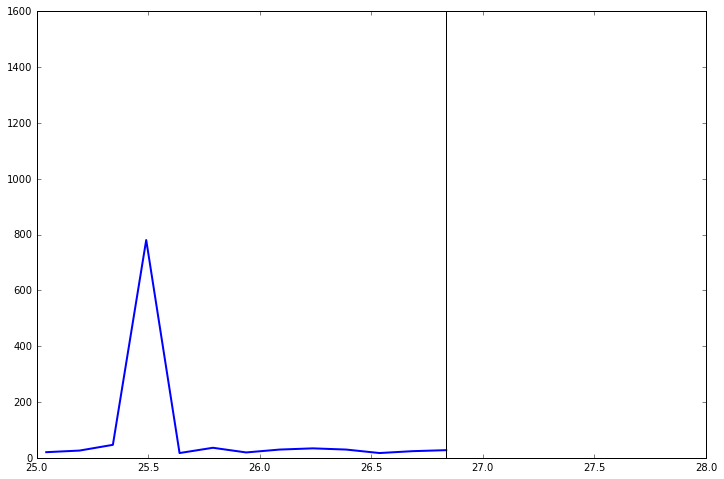

In [48]:
from matplotlib import animation
fig = plt.figure(figsize = figsz)
ax = plt.axes()#(ylim = [0, max_thresh*1.1]
line, = ax.plot([], [], lw=2)

def plotter(st):
    inds = (t_subset <= (st + FRAME_BREAK)) & (t_subset >= st)
    inds2 = (time_indexes <= (st + FRAME_BREAK)) & (time_indexes >= st)

    for start, end in zip(starts[inds2], ends[inds2]):
        ax.axvspan(start, end, alpha=0.5, color='red')
    return t_subset[inds], sum_Pxx_subset[inds]
    
ind = 0
next_ind = peaks.iloc[ind]['peak time']
last = df.index[0] 

# initialization function: plot the background of each frame
def init():
    global mainline
    ax.set_xlim(last, last + FRAME_BREAK)
    sub_df = df[(df.index >= last) & (df.index <= (last + FRAME_BREAK))]
    line, = ax.plot(sub_df.index.values, sub_df['signal'].values, 'b', lw=2)
    mainline = ax.axvline(x = sub_df.index[0], linewidth=1, c = 'k')
    return line,

def animate(i):
    global ind, next_ind, line, last, mainline
    mainline.set_xdata(df.index[i])
    if df.index[i] > (last + FRAME_BREAK):
        last += FRAME_BREAK
        sub_df = df[(df.index >= last) & (df.index <= (last + FRAME_BREAK))]
        line.set_data(sub_df.index.values,sub_df['signal'].values)
        ax.set_xlim(last, last + FRAME_BREAK)
        
        
    
    if df.index[i] >= next_ind:
        ind +=1
        ax.axvline(x = next_ind, linewidth=3, c = 'y')
        if ind == df.shape[0]:
            next_ind = 1e10
        else:
            next_ind = peaks['peak time'][ind]
        
    return line,

fps = df.shape[0] / TOTAL_TIME / SLOWDOWN

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= df.shape[0], interval=1, blit=True)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=rate)
anim.save('im.mp4', writer=writer)
'done'

In [49]:
_ = !ffmpeg -i im.mp4 -i subset_sound.wav -c:v copy -c:a aac -strict experimental output.mp4 -y

In [ ]:
# call our new function to display the animation
display_animation(anim, fps = fps)
# IPython.display.Audio("subset_sound.wav", autoplay=True)

In [ ]:
# HTML(anim.to_html5_video())

In [ ]:
sig_series = pd.Series(sig)
sig_series.index /= float(rate)
sig_series = sig_series[::rate/(2**7)]
sig_series.plot()

In [ ]:
# starts, ends

In [ ]:
# map(lambda x : (int(t[x - 2] * rate),int(t[x - 2] * rate + key_len_in_sec * rate)),   map(lambda x: np.sum(t <= x) , starts))

In [ ]:
fig = plt.figure(figsize = (15,6))
ax = plt.axes()
line, = ax.plot([], [], lw=2)

subX = sig_series.index.values
X = np.concatenate([np.array([0] * BREAK), subX ], axis = 0) 
Y = sig_series.values

starts

def plotter(st):
    inds = (X <= (st + FRAME_BREAK)) & (X >= st)
    inds2 = (time_indexes <= (st + FRAME_BREAK)) & (time_indexes >= st)
    for start, end in zip(starts[inds2], ends[inds2]):
        ax.axvspan(start, end, alpha=0.5, color='red')
    return X[inds], Y[inds]


    
    
ind = 0
next_ind = time_indexes[ind]
last = X[0] 

# initialization function: plot the background of each frame
def init():
    global point, startpoints, endpoints, mainline
    a,b = plotter(X[0])
    ax.set_xlim(last, last + FRAME_BREAK)
    line, = ax.plot(a, b, 'b', lw=2)
    mainline = ax.axvline(x = X[0], linewidth=1, c = 'k')
    return line,

# animation function.  This is called sequentially


def animate(i):
    global ind, next_ind, line, last, point, mainline
    mainline.set_xdata(X[i])
    if X[i] > (last + FRAME_BREAK):
        last += FRAME_BREAK
        a,b =  plotter(last)
        line.set_data(a,b)
        
        ax.set_xlim(last, last + FRAME_BREAK)
        
        
    
    if X[i] >= next_ind:
        ind +=1
        ax.axvline(x = next_ind, linewidth=3, c = 'y')
        if ind == len(indexes):
            next_ind = 1e10
        else:
            next_ind = time_indexes[ind]
        
    return line,

lenX = subX[-1] - subX[0]
fps = len(subX) / float(lenX) / SLOWDOWN

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(X), interval=1, blit=True)

In [ ]:
# call our new function to display the animation
display_animation(anim, fps = fps)
IPython.display.Audio("subset_sound.wav", autoplay=True)

In [ ]:
data = np.array(map(lambda x : sig[int(t[x - 2] * rate):int(t[x - 2] * rate + key_len_in_sec * rate)],   map(lambda x: np.sum(t <= x) , starts)))

In [ ]:
plt.plot(data[7])

In [ ]:
keystroke_feats = []
wave_len = 0.04
for i in range(len(indexes)):
    ind = indexes[i]
    plt.plot(t[ind - 2: ind + 6], sig_str[ind - 2: ind + 6], 'r')
    # Take exactly 40 ms
    key_start = int(t[ind - 2] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sig = sig[key_start:key_end]
    mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
    winstep=0.0025, numcep=16, nfilt=32, 
    lowfreq=400, highfreq=12000)
    keystroke_feats.append((i, np.concatenate(mfcc_feat[:5, :])))
